<a href="https://colab.research.google.com/github/Ariel29961/Ariel29961-Deep_Learning_and_Image_Understanding_course/blob/main/HW1_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

## Submission guidelines:

Your submission should only include this jupyter notebook named HW1_ID.ipynb.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you.
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).
8. **TIP: When there is a TODO before a missing code segment (or function), you can continue without implementing it right away; you will be referred to the missing segment later in the exercise.**

Q: What files do we need to upload to moodle?

A: You should fill in the missing parts in this Jupyter notebook and then submit it via moodle (without any additional files).

Q: How do I make sure everything works before I submit?

A: You should restart your kernel and rerun all cells. Make sure you get the desired output and that you meet exercise requirements. **This is an important step. You should include your desired outputs in the output cells to make your code easier to understand.**

#### Installs (if needed)

In [ ]:
### Blank cell for pip install
### EXAMPLE
# %pip install numpy (in some platforms or versions you will need to use '!' instead of '%'. like this - !pip install numpy)


### Make sure to restart the note book after the installs ###

#### Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time

### if any import fails with the following Error - "ModuleNotFoundError: No module named 'Module'", use the blank cell from above to install the package using %pip install 'Module'

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [ ]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [ ]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH)

Downloading, This might take several minutes.

Download finished. Extracting files.
Done.


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.

In [ ]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
# portion from the test dataset a validation dataset for hyperparameter optimization
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
# test dataset, without overlap with train/validation
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

    plane	      car	      car	      car


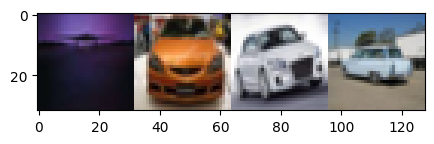

In [ ]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False));

## Data Preprocessing Part 2

We have included several image processing functions. Notice the following in particular: We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick.

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [ ]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1))

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [ ]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***

        Inputs:
        - X: array of data - a 2D array of size (num_instances=N, num_features)
        - y: 1-dimensional array of length N with binary labels

        This function has no return value

        """
        pass

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label.
        *** Subclasses will override this. ***

        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1).
        """
        pass

    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances
        that are classified correctly.

        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """

        accuracy = 0.0
        ###########################################################################
        # TODO: Implement this method.                                            #
        ###########################################################################
        #                          START OF YOUR CODE                             #
        ###########################################################################



        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

        return accuracy


    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances = X.shape[0]
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            X_batch = None
            y_batch = None
            ###########################################################################
            # Create X_batch and y_batch. Call the loss method to get the loss value  #
            # and grad (the loss function is being override, see the loss             #
            # function return values).                                                #
            # Finally, append each of the loss values created in each iteration       #
            # to loss_history.                                                        #
            ###########################################################################
            #                          START OF YOUR CODE                             #
            ###########################################################################






            ###########################################################################
            #                           END OF YOUR CODE                              #
            ###########################################################################
            # TODO:                                                                   #
            # Perform parameter update                                                #
            # Update the weights using the gradient and the learning rate.            #
            ###########################################################################
            #                          START OF YOUR CODE                             #                                                         #
            ###########################################################################


            ###########################################################################
            #                       END OF YOUR CODE                                  #
            ###########################################################################

            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history


    def loss(self, X, y):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

## Linear perceptron
Our first linear classifier will include a linear function that maps images to score/scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

In the multiclass case, W will be a matrix that maps the input into scores (score for each class) and the final prediction will be the class with the highest score.
The binary case is a special case where you can choose to implement W as a 2 dim matrix or as a vector. The first option treats the binary problem as a multiclass problem with 2 classes, therefore, the prediction will be the class with the highest score. In case you choose to implement W as a vector (which map the input to a single score), the final prediction is done by:


if w·x+b > 0 classify the target as 1, else classify the target as 0.

**Important Note** - In this exercise we focus on the binary case, and you should implement W as a vector.

Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use `w` for convenience. You may initialize `w` randomly ([0,1] or [-1,1]).

Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(5 Points)**

In [ ]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        ###########################################################################
        # Initiate the parameters of your model.                                  #
        # You can assume y takes values 0...K-1 where K is number of classes      #
        ###########################################################################
        #                          START OF YOUR CODE                             #
        ###########################################################################
        pass

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # Implement this method.                                                  #
        ###########################################################################
        #                          START OF YOUR CODE                             #
        ###########################################################################



        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        # perceptron_loss_vectorized will be implemented later
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [ ]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

      car	    plane	    plane	      car


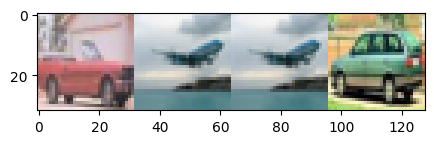

In [ ]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True))
plt.show()

In [ ]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

## Evaluation

Complete the class method `calc_accuracy`. **(5 Points)**

In [ ]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

**Explain why the accuracy on the training dataset is around 50% (remember, the model is not trained yet). **(5 Points)****

Answer:

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [ ]:
def perceptron_loss_naive(W, X, y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################








    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [ ]:
W = np.random.randn(3073, 1) * 0.0001

In [ ]:
%%time
loss_naive, _ = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive))

loss: 0.000000
CPU times: total: 0 ns
Wall time: 0 ns


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. **(15 points)**

In [ ]:
def perceptron_loss_vectorized(W, X, y):
    """
    Vectorized version of perceptron_loss_naive. instead of loops, should use
    numpy vectorization.

    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement a vectorized version of the perceptron loss, storing the       #
    # result in loss and the gradient in dW                                     #
    #############################################################################






    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [ ]:
%%time
loss_vectorized, _ = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized))

You might not see big changes in time due to other computing factors. In big enough datasets it would be crucial to use the vectorized version.

We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class. (**15 points**)

In [ ]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7,
                                num_iters=1500, verbose=True)

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.0
Testing accuracy:  0.0


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. **(5 points)**


In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################










################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))

print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. **(10 Points)**

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions.

In [ ]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.

    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    #############################################################################
    # Implement the function                                                    #
    #############################################################################




    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [ ]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        # Initiate the parameters of your model.                                  #
        ###########################################################################



        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # Implement this method.                                                  #
        ###########################################################################




        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        # will be implemented later
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [ ]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

      car	    plane	    plane	    plane


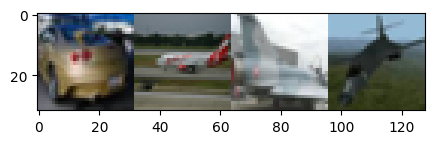

In [ ]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch))

In [ ]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

In [ ]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.0


## Binary cross-entropy

Your code for this section will written in the next cell.

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W. (**20 points**)

In [ ]:
def binary_cross_entropy(W, X, y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1).
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################






    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [ ]:
W = np.random.randn(3073, 1) * 0.0001

In [ ]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.000000
CPU times: total: 0 ns
Wall time: 0 ns


You are provided with a gradient test in the next cells:

In [ ]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [ ]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

If implemented correctly, the training procedure you already implemented should work.

In [ ]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train,
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  0.0
Testing accuracy:  0.0


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. **(5 points)**

In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################











################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))

print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

# The End!